# Inconsistent adversaries

Adversaries calculated on different machines can generate significantly different adversaries and as a consequence confidences.

The reason seems to be a dependency of the gradient calculations on the hardware. On the same machine the results are consistent.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks')

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset

from modules.fgsm import*
from modules.bim import*
from modules.illm import*

In [2]:
## Load model and data
model = models.googlenet(pretrained=True)
#model = models.resnet50(pretrained=True)
model.eval();

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

In [4]:
def predict_insp(model, image, target_label, return_grad=False):
    '''
    Predicts the class of the given image and compares the prediction with the provided label.
    
    Inputs:
    model             -- net
    image             -- Input image as tensor of shape (1, 3, 224, 224)
    target_label      -- Target label as tensor of shape (1)
    return_grad       -- Returns gradient if set True
    
    Returns:
    predicted_classes -- Numpy array of top 5 predicted class indices
    confidences       -- Numpy array of top 5 confidences in descending order
    gradient          -- None if return_grad=False. Otherwise the gradient from the prediction
                         as a tensor of shape ().
    '''      
     
    if return_grad == True:
        image.requires_grad=True
        prediction = model(image)
               
        # Zero gradients
        model.zero_grad()

        # Calculate loss using the class index for pandas and get gradient
        loss = F.nll_loss(prediction, target_label)
        loss.backward()
        gradient = image.grad.data
        
    else:           
        gradient = None
        with torch.no_grad():
            prediction = model(image)  

    # Get class index and confidence for prediction 
    prediction = torch.nn.functional.softmax(prediction[0].cpu().detach(), dim=0).numpy()
   
    # Get top 5 class indices
    predicted_classes = prediction.argsort()[-5:][::-1]
        
    # Get largest confidences
    confidences = prediction[predicted_classes]
    
    return predicted_classes, confidences, gradient

In [10]:
def attack_BIM_insp(mean, std, model, image, class_index, epsilon, alpha, num_iterations=10):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    mean           -- Mean from data preparation
    std            -- Standard deviation from data preparation
    model          -- Network under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    class_index    -- Label from image as numpy array   
    epsilon        -- Hyperparameter for sign method. Has to be scaled to epsilon/255
    alpha          -- Hyperparameter for iterative step as absolute value. Has to be scaled to alpha/255
    num_iterations -- Number of iterations to perform. Default is 10. It is recommended to use the heuristic from the
                      paper "Adversarial Examples in the Pysical World" to determine the number of iterations
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''

    # Convert label to torch tensor of shape (1)
    class_index = torch.tensor([class_index])

    # Check input image and label shapes
    #assert(image.shape == torch.Size([1, 3, 224, 224]))
    #assert(class_index.shape == torch.Size([1]))
    print("Image clean and initialized adversary:")
    print(image.sum())
    
    # Initialize adversarial image as image according to equation 2.1
    image_adver = image.clone()    
    print(image_adver.sum())
    
    # Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    print("Normalized range:")
    print(zero_normed.sum())
    
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    print(max_normed.sum())
    
    # Calculate normalized alpha
    alpha_normed = [alpha/s for s in std]
    alpha_normed = torch.tensor(alpha_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    print("Alpha and epsilon:")
    print(alpha_normed.sum())
    
    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    print(eps_normed.sum())
    
    # Calculate the maximum change in pixel value using epsilon to be later used in clip function
    image_plus = image + eps_normed
    image_minus = image - eps_normed
    print("Changes in pixel values:")
    print(image_plus.sum())
    print(image_minus.sum()) 
    print("\n---------\nIterative stuff\n--------")
    
    predictions_list = []
    grad_list = []
    adv_list = []
       
    for i in range(num_iterations):
        
        # Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        print(image_adver.sum())
        adv_list.append(np.abs(image_adver.numpy()).sum())
        image_adver.requires_grad=True
        
        # Compute cost with example image_adversarial        
        pred = model(image_adver)
        predictions_list.append(pred)
        loss = F.nll_loss(pred, class_index)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data
        print(grad_x.sum()) # Different on different machines in first iteration
        grad_list.append(np.abs(grad_x.numpy()).sum())
        
        # Check if gradient exists
        assert(image_adver.grad is not None)
               
        # Compute X_prime according to equation 2.2
        image_prime = image_adver + alpha_normed * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
      
        # Equation 2.3 part 1
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(zero_normed, third_part_1)
              
        # Equation 2.3 part 2
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(max_normed, image_adver) 
        
         
    # Convert predictions to numpy arrays
    predictions_list_np = []
    for j in range(num_iterations):
        arr = predictions_list[j].detach().squeeze(0).numpy()
        predictions_list_np.append(arr)                     
                             
    out = pd.DataFrame()
    out["Predictions"] = predictions_list_np
    out["Gradient_sum"] = grad_list
    out["Adversaries"] = adv_list
    
    #out.to_csv("results/Analyze_attack_BIM-Predictions_Mac.csv")

    return image_adver

In [6]:
def attack_ILLM_insp(mean, std, model, image, class_index, epsilon, alpha, num_iterations=10):
    '''
    Applies given number of steps of the Iterative Least Likely Method (ILLM) attack on the input image.
    
    Inputs:
    mean           -- Mean from data preparation
    std            -- Standard deviation from data preparation
    model          -- Network under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    class_index    -- Label from image as numpy array   
    epsilon        -- Hyperparameter for sign method. Has to be scaled to epsilon/255
    alpha          -- Hyperparameter for iterative step as absolute value. Has to be scaled to alpha/255
    num_iterations -- Number of iterations to perform. Default is 10. It is recommended to use the heuristic from the
                      paper "Adversarial Examples in the Pysical World" to determine the number of iterations
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''

    # Convert label to torch tensor of shape (1)
    class_index = torch.tensor([class_index])

    # Check input image and label shapes
    #assert(image.shape == torch.Size([1, 3, 224, 224]))
    #assert(class_index.shape == torch.Size([1]))
    print("Image clean and initialized adversary:")
    print(image.sum())
    # Initialize adversarial image as image according to equation 3.1
    image_adver = image.clone()   
    
    print(image_adver.sum())
    # Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    print("Normalized range:")
    print(zero_normed.sum())
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    print(max_normed.sum())
    # Calculate normalized alpha
    alpha_normed = [alpha/s for s in std]
    alpha_normed = torch.tensor(alpha_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    print("Alpha and epsilon:")
    print(alpha_normed.sum())
    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    print(eps_normed.sum())
    # Calculate the maximum change in pixel value using epsilon to be later used in clip function
    image_plus = image + eps_normed
    image_minus = image - eps_normed
    print("Changes in pixel values:")
    print(image_plus.sum())
    print(image_minus.sum()) 
    print("\n---------\nIterative stuff\n--------")
    
    predictions_list = []
    grad_list = []
    adv_list = []
    
    for i in range(num_iterations):
        
        # Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        print(image_adver.sum())
        adv_list.append(np.abs(image_adver.numpy()).sum())
        image_adver.requires_grad=True
        
        # Compute gradient of cost with least likely class     
        pred = model(image_adver)
        predictions_list.append(pred)
        least_likeliest_class = torch.argmin(pred)
        least_likeliest_class.unsqueeze_(0)     
        loss = F.nll_loss(pred, least_likeliest_class)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data   
        print(grad_x.sum()) # Different on different machines in first iteration
        grad_list.append(np.abs(grad_x.numpy()).sum())
        
        # Check if gradient exists
        assert(image_adver.grad is not None)
               
        # Compute X_prime according to equation 3.2
        image_prime = image_adver - alpha_normed * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
      
        # Equation 3.3 part 1
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(zero_normed, third_part_1)
              
        # Equation 3.3 part 2
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(max_normed, image_adver)                        
    
    # Convert predictions to numpy arrays
    predictions_list_np = []
    for j in range(num_iterations):
        arr = predictions_list[j].detach().squeeze(0).numpy()
        predictions_list_np.append(arr)                     
    
                            
    out = pd.DataFrame()
    out["Predictions"] = predictions_list_np
    out["Gradient_sum"] = grad_list
    out["Adversaries"] = adv_list
    
    #out.to_csv("results/Analyze_attack_ILLM-Predictions_Mac_2.csv")
        
    return image_adver

## 1. Are predictions consistent on the same machine?

In [7]:
## Set parameters
sample = 162


num_pred = 20


## ====================================================


# Get data
image_clean, class_index = data_loader.dataset[sample]
image_clean.unsqueeze_(0)
class_index.unsqueeze_(0)



predicted_classes_list = []
confidences_list = []

predicted_classes_list_grad = []
confidences_list_grad  = []
gradients_list_grad  = []


# Each one num_pred times:
for pred in range(num_pred):
    

    ## Predict without gradient
    predicted_classes, confidences, _ = predict_insp(model, image_clean, class_index, return_grad=False)

    predicted_classes_list.append(predicted_classes)
    confidences_list.append(confidences)


    ## Predict with gradient
    predicted_classes_grad, confidences_grad, gradient_grad = predict_insp(model, image_clean, class_index, return_grad=True)
    predicted_classes_list_grad.append(predicted_classes_grad)
    confidences_list_grad.append(confidences_grad)
    gradients_list_grad.append(gradient_grad)

    
print("\n----------Attacks complete! Analyzing results...")
print("Confidences:")
for i in range(num_pred):
    print(confidences_list[i] == confidences_list_grad[i])



----------Attacks complete! Analyzing results...
Confidences:
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]


As seen before the clean predictions are the same on each machine. They differ slghtly on different ones.

In [8]:
confidences_list

[array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtype=float32),
 array([0.9270867 , 0.01065249, 0.00889963, 0.00735884, 0.00350303],
       dtyp

## 2. Are adversaries generated on different machines the same?

The `predict` method produces consistent results. The predictions differ slightly on different machines.

The differences in confidence seem to come from the `attack_ILLM` function. Since the adversaries it produces are consistent on the same machine, a hardware dependency of this method seems to exists.

In [11]:
sample = 162

epsilon = 4/255

num_iterations = 20

## ====================================================
alpha = 1/255
#num_iterations = int(np.min([np.ceil( (epsilon/alpha) + 4 ), np.ceil( 1.25 * epsilon/alpha ) ]))

image_clean, class_index = data_loader.dataset[sample]
image_clean.unsqueeze_(0)
class_index.unsqueeze_(0)

im_adv = attack_BIM_insp(mean, std, model, image_clean, class_index, epsilon, alpha, num_iterations=num_iterations)

print("\n------Adversary:\n{}".format(im_adv.sum()))

Image clean and initialized adversary:
tensor(-49353.2031)
tensor(-49353.2031)
Normalized range:
tensor(-5.9581)
tensor(7.3175)
Alpha and epsilon:
tensor(0.0521)
tensor(0.2082)
Changes in pixel values:
tensor(-38904.4531)
tensor(-59801.9961)

---------
Iterative stuff
--------
tensor(-49353.2031)
tensor(-3.0170)
tensor(-49350.1836)
tensor(-0.8813)
tensor(-49352.7461)
tensor(0.1110)
tensor(-49363.9102)
tensor(-0.8150)
tensor(-49356.3750)
tensor(-0.2985)
tensor(-49364.2188)
tensor(-1.7385)
tensor(-49378.8984)
tensor(-0.4587)
tensor(-49372.6953)
tensor(-1.8864)
tensor(-49368.7539)
tensor(-0.5232)
tensor(-49369.5391)
tensor(-0.2500)
tensor(-49377.6289)
tensor(-1.0638)
tensor(-49380.9453)
tensor(-0.5063)
tensor(-49384.7383)
tensor(0.2050)
tensor(-49386.7969)
tensor(-0.8235)
tensor(-49395.8789)
tensor(-0.5693)
tensor(-49392.1875)
tensor(-1.8196)
tensor(-49385.4766)
tensor(0.0898)
tensor(-49387.4492)
tensor(-1.3323)
tensor(-49378.3125)
tensor(0.9031)
tensor(-49384.3242)
tensor(-1.6819)

-----

In [12]:
sample = 162

epsilon = 4/255

num_iterations = 20

## ====================================================
alpha = 1/255
#num_iterations = int(np.min([np.ceil( (epsilon/alpha) + 4 ), np.ceil( 1.25 * epsilon/alpha ) ]))

image_clean, class_index = data_loader.dataset[sample]
image_clean.unsqueeze_(0)
class_index.unsqueeze_(0)

im_adv = attack_ILLM_insp(mean, std, model, image_clean, class_index, epsilon, alpha, num_iterations=num_iterations)

print("\n------Adversary:\n{}".format(im_adv.sum()))

Image clean and initialized adversary:
tensor(-49353.2031)
tensor(-49353.2031)
Normalized range:
tensor(-5.9581)
tensor(7.3175)
Alpha and epsilon:
tensor(0.0521)
tensor(0.2082)
Changes in pixel values:
tensor(-38904.4531)
tensor(-59801.9961)

---------
Iterative stuff
--------
tensor(-49353.2031)
tensor(-0.2715)
tensor(-49348.1602)
tensor(-0.1905)
tensor(-49348.0625)
tensor(0.0945)
tensor(-49347.1172)
tensor(1.2469)
tensor(-49349.1680)
tensor(-0.0668)
tensor(-49344.1914)
tensor(0.2815)
tensor(-49338.9062)
tensor(0.9225)
tensor(-49339.0586)
tensor(-0.1819)
tensor(-49341.4102)
tensor(0.1033)
tensor(-49343.3008)
tensor(-0.6606)
tensor(-49352.0938)
tensor(-0.6595)
tensor(-49344.7031)
tensor(0.4615)
tensor(-49339.9844)
tensor(0.4779)
tensor(-49343.7305)
tensor(-0.4920)
tensor(-49335.7617)
tensor(0.1285)
tensor(-49338.2188)
tensor(0.9081)
tensor(-49347.2461)
tensor(-0.0371)
tensor(-49346.4492)
tensor(-0.1338)
tensor(-49346.7148)
tensor(-0.3240)
tensor(-49345.2070)
tensor(0.3922)

------Adver

In [13]:
attacks_mac = pd.read_csv("results/Analyze_attack_ILLM-Predictions_Mac.csv", index_col=0)
attacks_mac_2 = pd.read_csv("results/Analyze_attack_ILLM-Predictions_Mac_2.csv", index_col=0)
attacks_colab = pd.read_csv("results/Analyze_attack_ILLM-Predictions_Colab.csv", index_col=0)

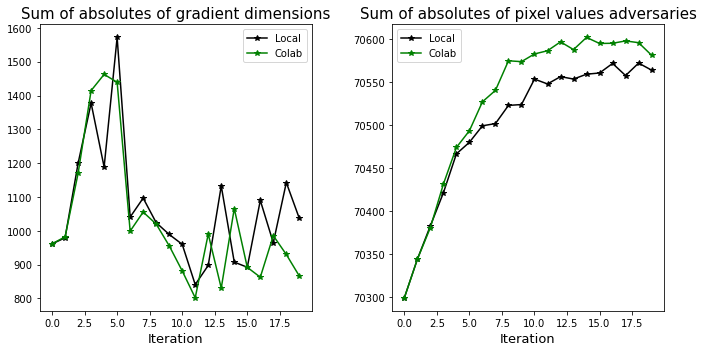

In [24]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 5))

## Left: Accuracies
axs[0].plot(attacks_mac["Gradient_sum"], "-*", color='black', label='Local')
axs[0].plot(attacks_colab["Gradient_sum"], "-*", color='green', label='Colab')

axs[0].set_title("Sum of absolutes of gradient dimensions", fontsize=15)
axs[0].legend()
axs[0].set_xlabel("Iteration", fontsize=13)

## Right: Confidences
axs[1].plot(attacks_mac["Adversaries"], "-*", color='black', label='Local')
axs[1].plot(attacks_colab["Adversaries"], "-*", color='green', label='Colab')
axs[1].set_title("Sum of absolutes of pixel values adversaries", fontsize=15)
axs[1].legend()
axs[1].set_xlabel("Iteration", fontsize=13)

## Save plot
fig.tight_layout()
fig.savefig("plots/Appendix/Hardware_dependency.png")